In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, MeanShift, estimate_bandwidth, DBSCAN

from sklearn.metrics.cluster import silhouette_score, adjusted_rand_score
from sklearn.metrics import normalized_mutual_info_score

In [2]:
penguins = sns.load_dataset("penguins")
penguins = penguins.sample(frac=1).reset_index(drop=True)
penguins.dropna(inplace=True)
penguins

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Chinstrap,Dream,45.2,17.8,198.0,3950.0,Female
1,Gentoo,Biscoe,49.5,16.2,229.0,5800.0,Male
2,Gentoo,Biscoe,46.5,13.5,210.0,4550.0,Female
3,Adelie,Dream,33.1,16.1,178.0,2900.0,Female
4,Gentoo,Biscoe,44.0,13.6,208.0,4350.0,Female
...,...,...,...,...,...,...,...
339,Chinstrap,Dream,55.8,19.8,207.0,4000.0,Male
340,Chinstrap,Dream,43.5,18.1,202.0,3400.0,Female
341,Gentoo,Biscoe,49.1,14.8,220.0,5150.0,Female
342,Gentoo,Biscoe,49.2,15.2,221.0,6300.0,Male


데이터 준비 완료. 333개의 샘플과 4개의 피처 사용.

K-Means 최적의 k를 찾는 중...


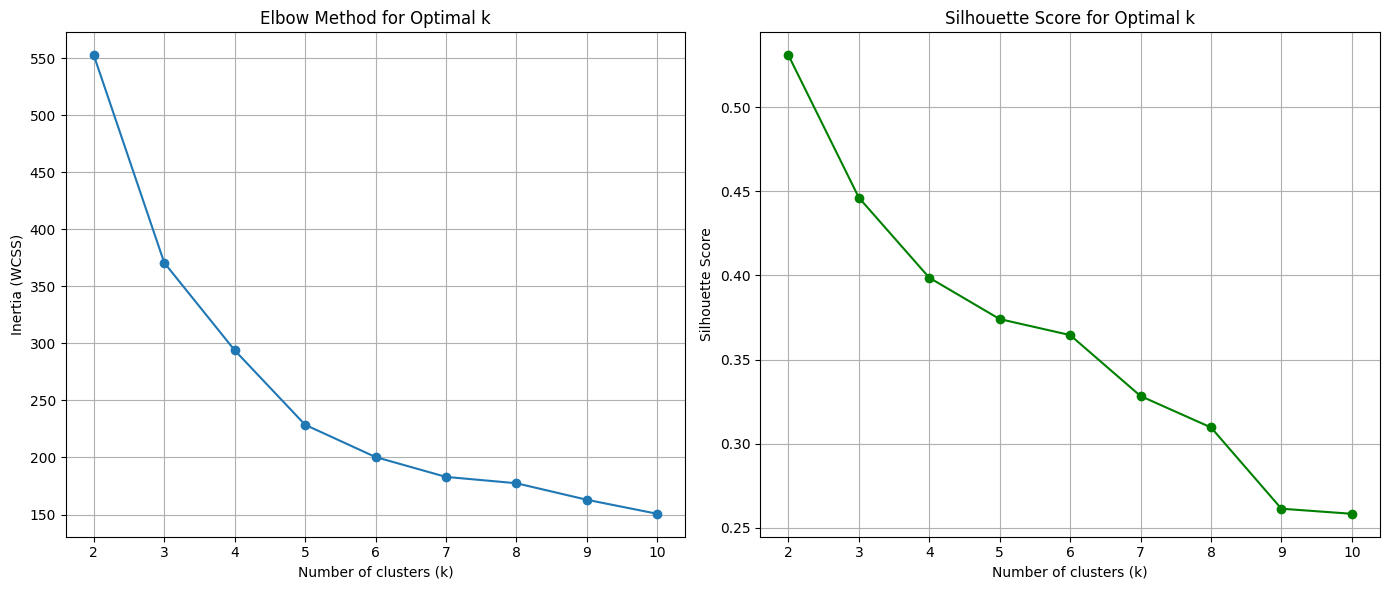

그래프 분석 결과, 최적의 k는 3 (으)로 결정합니다.

     각 모델별 군집 평가 점수


,model,ari,nmi,silhouette
0,k-means,0.799421,0.789932,0.446193
1,mean-shift,0.804105,0.788941,0.425754
2,dbscan,0.627861,0.673080,0.446192


In [7]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, MeanShift, estimate_bandwidth, DBSCAN
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score
# display 함수는 Jupyter Notebook/Colab에서 DataFrame을 표로 예쁘게 출력할 때 사용합니다.
from IPython.display import display

# 1. 데이터 준비 (피처 및 스케일링)
# 'penguins' DataFrame이 이미 로드되어 있고 dropna()가 적용된 상태라고 가정합니다.

# 사용할 피처 선택 (컬럼 이름에 _(언더스코어) 사용)
features = ['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']
X = penguins[features]

# 실제 정답 레이블 (평가용)
y_true = penguins['species']

# 피처 스케일링
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"데이터 준비 완료. {X_scaled.shape[0]}개의 샘플과 {X_scaled.shape[1]}개의 피처 사용.")


# 2. K-Means: 최적의 k 찾기 (Elbow & Silhouette 그래프)
inertia_list = []      # WCSS (관성) 값을 저장할 리스트
silhouette_list = [] # 실루엣 점수를 저장할 리스트
k_range = range(2, 11) # k=2 부터 10까지 테스트

print("\nK-Means 최적의 k를 찾는 중...")

for k in k_range:
    kmeans = KMeans(n_clusters=k, n_init='auto', random_state=42)
    kmeans.fit(X_scaled)
    inertia_list.append(kmeans.inertia_)
    silhouette_list.append(silhouette_score(X_scaled, kmeans.labels_))

# 3. 그래프 시각화
plt.figure(figsize=(14, 6))

# 3-1. Elbow Method (엘보우 그래프)
plt.subplot(1, 2, 1)
plt.plot(k_range, inertia_list, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia (WCSS)')
plt.grid(True)

# 3-2. Silhouette Score (실루엣 그래프)
plt.subplot(1, 2, 2)
plt.plot(k_range, silhouette_list, marker='o', color='green')
plt.title('Silhouette Score for Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.grid(True)

plt.tight_layout()
plt.show()

k_optimal = 3
print(f"그래프 분석 결과, 최적의 k는 {k_optimal} (으)로 결정합니다.")


# 4. 세 가지 모델 학습
# 4-1. K-Means (결정된 k=3 사용)
kmeans = KMeans(n_clusters=k_optimal, n_init='auto', random_state=42)
kmeans_labels = kmeans.fit_predict(X_scaled)

# 4-2. Mean Shift
bandwidth = estimate_bandwidth(X_scaled, quantile=0.2, n_samples=len(X_scaled))
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms_labels = ms.fit_predict(X_scaled)

# 4-3. DBSCAN
dbscan = DBSCAN(eps=0.7, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_scaled)


# 5. 각 모델의 평가 점수를 DataFrame으로 출력 (★ 요청하신 부분 ★)
print("\n" + "="*40)
print("     각 모델별 군집 평가 점수")
print("="*40)

model_labels = {
    "k-means": kmeans_labels,
    "mean-shift": ms_labels,
    "dbscan": dbscan_labels
}

# 결과를 저장할 리스트
results_list = []

for name, labels in model_labels.items():
    # ARI (Adjusted Rand Index)
    ari = adjusted_rand_score(y_true, labels)
    
    # NMI (Normalized Mutual Info)
    nmi = normalized_mutual_info_score(y_true, labels)
    
    # Silhouette Score (실루엣 점수)
    # 클러스터가 1개만 감지되면(e.g., DBSCAN에서 노이즈만 있거나) 실루엣 점수 계산이 불가합니다.
    silhouette = 0.0 # 기본값
    unique_labels = len(set(labels))
    if unique_labels > 1 and unique_labels < len(X_scaled):
        try:
            silhouette = silhouette_score(X_scaled, labels)
        except ValueError:
            silhouette = 0.0 # 예외 발생 시 0으로 처리
    
    # 딕셔너리로 결과 저장
    results_list.append({
        "model": name,
        "ari": ari,
        "nmi": nmi,
        "silhouette": silhouette
    })

# 리스트를 pandas DataFrame으로 변환
metrics_df = pd.DataFrame(results_list)

# DataFrame 출력 (display() 함수가 표를 더 예쁘게 보여줍니다)
display(metrics_df)